## **Student Name: Bakhtiyor Sohibnazarov** \
**Student ID: SOH22590018** \
**Course: Computer Science. Artificial Intelligence Module** \
**Purpose: Coursework - 2** \
**Last Update: 01.03.2025**

## CourseWork - 2. Sustainable Transportation Solutions
#### Task 1: Define the Map
A map of this searching problem is given in Figure 2. The cities highlighted in red **(Manchester,
Holyhead, Liverpool, York, Carlisle, Newcastle, Glasgow, Edinburgh, Oban, Aberdeen,
Inverness)** are used as delivery nodes. The roads and distances between these cities are
highlighted in white.
- Develop codes and functions to store the map information in your program.
- Define the start point and end point: Ideally, your program should ask the user to select the start and end cities for the delivery route. (At a minimum, your program should consider the case where Manchester is the starting point and Inverness is the
destination.)

In [381]:
# Import Dependencies. NetworkX for graph. Plotly for Map Visualization
import networkx as nx
import plotly.graph_objects as go
from collections import deque

# Class to represent the Environment
class Environment:
    def __init__(self):
        # Creates Graph. Stores actual graph. Can be modifies within the class
        self.graph = nx.Graph()
        # Declaration of City Coordinates
        self.city_coordinates = {
            'Manchester': (53.4808, -2.2426),
            'Liverpool': (53.4084, -2.9916),
            'Holyhead': (53.3097, -4.6332),
            'York': (53.9590, -1.0815),
            'Carlisle': (54.8925, -2.9329),
            'Newcastle': (54.9783, -1.6178),
            'Glasgow': (55.8642, -4.2518),
            'Edinburgh': (55.9533, -3.1883),
            'Oban': (56.4152, -5.4716),
            'Aberdeen': (57.1497, -2.0943),
            'Inverness': (57.4778, -4.2247)
        }
        # Builds Graph
        self._build_graph()
        # Static traffic factor
        self._apply_traffic_factors()

    def _build_graph(self):
        """Build the graph from the adjacency list."""
        map_graph = {
            'Manchester': {'Liverpool': 40, 'York': 60, 'Newcastle': 130, 'Edinburgh': 220, 'Carlisle': 120},
            'Liverpool': {'Manchester': 40, 'Holyhead': 90},
            'Holyhead': {'Liverpool': 90},
            'York': {'Manchester': 60, 'Newcastle': 80},
            'Carlisle': {'Manchester': 120, 'Glasgow': 100},
            'Newcastle': {'Manchester': 130, 'York': 80, 'Edinburgh': 110},
            'Glasgow': {'Carlisle': 100, 'Edinburgh': 40, 'Oban': 90, 'Aberdeen': 140, 'Inverness': 170},
            'Edinburgh': {'Newcastle': 110, 'Glasgow': 40, 'Manchester': 220},
            'Oban': {'Glasgow': 90, 'Inverness': 110},
            'Aberdeen': {'Glasgow': 140, 'Inverness': 110},
            'Inverness': {'Oban': 110, 'Aberdeen': 110, 'Glasgow': 170}
        }
        # For loop that Modifies created NetworkX graph.
        for city, neighbors in map_graph.items():
            for neighbor, dist in neighbors.items():
                self.graph.add_edge(city, neighbor, weight=dist)
        for city, coords in self.city_coordinates.items():
            self.graph.nodes[city]['pos'] = coords

        # Store original distances separately
        self.original_distances = {}
        for u, v, data in self.graph.edges(data=True):
            self.original_distances[(u, v)] = data['weight']
            self.original_distances[(v, u)] = data['weight']

    def _apply_traffic_factors(self):
        """Apply static traffic factors to edges."""
        # Define static traffic factors for specific edges
        # 1 - No Traffic
        # 1.2 - Light Traffic
        # 1.4 - Moderate Traffic
        # 1.6 - Heavy Traffic
        # 1.8 - Severe Traffic
        print("[DEBUG] Applying traffic factors")
    
        # Traffic factors with consistent ordering for edges
        self.traffic_factors = {
            ('Manchester', 'Liverpool'): 1.0,
            ('Manchester', 'York'): 1.0,
            ('Manchester', 'Newcastle'): 1.0,
            ('Manchester', 'Edinburgh'): 1.0,
            ('Manchester', 'Carlisle'): 1.0,
            ('Liverpool', 'Holyhead'): 1.0,
            ('York', 'Newcastle'): 1.0,
            ('Carlisle', 'Glasgow'): 1.0,
            ('Newcastle', 'Edinburgh'): 1.0,
            ('Glasgow', 'Edinburgh'): 1.0,
            ('Oban', 'Inverness'): 1.0,
            ('Aberdeen', 'Inverness'): 1.0,
            ('Glasgow', 'Inverness'): 1.0
        }
    
        # Apply traffic factors to edges. Modify defined graph.
        for (u, v), factor in self.traffic_factors.items():
            # Ensure we are storing edges consistently as (min(u, v), max(u, v))
            ordered_edge = (min(u, v), max(u, v))
    
            # Check if the edge exists in the graph and apply the factor
            if self.graph.has_edge(ordered_edge[0], ordered_edge[1]):
                self.graph[ordered_edge[0]][ordered_edge[1]]['weight'] *= factor
    
        print("[DEBUG] Traffic factors applied successfully.")


    # Returns nodes
    def get_cities(self):
        """Return a list of cities."""
        return list(self.graph.nodes())

    # Returns city coordinates
    def get_city_coordinates(self, city):
        """Return the coordinates of a city."""
        return self.city_coordinates.get(city, (0, 0))

    def calculate_path_distance(self, path):
        """Calculate the total distance of a path, considering traffic factors."""
        total_distance = 0
        max_traffic_factor = 1.0
        
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
    
            # Normalize the edge to handle undirected graph (min(u, v), max(u, v))
            ordered_edge = (min(u, v), max(u, v))
            
            if self.graph.has_edge(u, v):
                edge_weight = self.graph[u][v]['weight']
                total_distance += edge_weight
    
                # Get the traffic factor for the normalized edge
                traffic_factor = self.traffic_factors.get(ordered_edge, 1.0)
                max_traffic_factor = max(max_traffic_factor, traffic_factor)
            else:
                return None  # No edge exists between these nodes
    
        return total_distance, max_traffic_factor


#### Task 2: Define the searching algorithms

Your program should implement at least three searching algorithms to determine the optimal
delivery route between cities:
- Depth-First Search (DFS)
- Breadth-First Search (BFS)
- A* Search
- Add a 4th algorithm and explain why you chose this algorithm (e.g., Dijkstra’s
algorithm for shortest paths, or Genetic Algorithms for optimization).

In [383]:
# Class to represent the Agent (Pathfinding)
class Search:
    def __init__(self, environment):
        self.env = environment
        
    # Apply NetworkX builtin Djikstra Algorithm. Returns Path
    def dijkstra(self, start, end):
        """Find the shortest path using Dijkstra's algorithm."""
        try:
            path = nx.dijkstra_path(self.env.graph, source=start, target=end, weight='weight')
            return path
        except nx.NetworkXNoPath:
            return None

    # Apply NetworkX builtIn A-start algorithm, Need to specify heuristic.
    def astar(self, start, end):
        """Find the shortest path using A* algorithm."""
        def heuristic(node, goal):
            # Euclidean distance as heuristic
            return ((self.env.city_coordinates[node][0] - self.env.city_coordinates[goal][0]) ** 2 +
                    (self.env.city_coordinates[node][1] - self.env.city_coordinates[goal][1]) ** 2) ** 0.5
        try:
            # Returns Path to the target
            return nx.astar_path(self.env.graph, source=start, target=end, heuristic=heuristic, weight='weight')
        except nx.NetworkXNoPath:
            return None

    # Implemented manually as builtIn Function of NetworkX does not support weighted graphs
    def bfs(self, start, end):
        """Find a path using Breadth-First Search (manually implemented)."""
        if start == end:
            return [start]

        visited = set()
        queue = deque()
        queue.append((start, [start]))  # (current_node, path)

        while queue:
            current_node, path = queue.popleft()
            visited.add(current_node)

            for neighbor in self.env.graph.neighbors(current_node):
                if neighbor == end:
                    return path + [neighbor]
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))

        return None  # No path found

    # Implemented manually as builtIn Function of NetworkX does not support weighted graphs
    def dfs(self, start, end):
        """Find a path using Depth-First Search (manually implemented)."""
        if start == end:
            return [start]

        visited = set()
        stack = [(start, [start])]  # (current_node, path)

        while stack:
            current_node, path = stack.pop()
            visited.add(current_node)

            for neighbor in self.env.graph.neighbors(current_node):
                if neighbor == end:
                    return path + [neighbor]
                if neighbor not in visited:
                    visited.add(neighbor)
                    stack.append((neighbor, path + [neighbor]))

        return None  # No path found

#### Task 3: Show the results
Given the start point and end point, your program should run the searching algorithms and
display the results to the user. The program should:
- Display the suggested path provided by each algorithm.
- Show the total driving distance for each route.

In [385]:

def visualize_path(environment, path, algorithm_name):
    """Visualize the path on a map using Plotly and print carbon emissions."""
    if path is None:
        print(f"No path found for {algorithm_name}.")
        return

    # Emission factors (in kg/mile)
    EMISSION_FACTORS = {
        "bicycle": 0.0,    # 0 g/mile
        "ev": 0.1,         # 100 g/mile
        "petrol_car": 0.4  # 400 g/mile
    }

    # Calculate total distance
    total_distance, max_traffic_factor = environment.calculate_path_distance(path)
    if total_distance is None:
        print("Invalid path. Cannot calculate distance.")
        return


    # Calculate the initial distance (without traffic factors)
    initial_distance = 0
    for i in range(len(path) - 1):
        # Access the original distance from the dictionary
        initial_distance += environment.original_distances.get((path[i], path[i + 1]), 0)



    # Print out the traffic conditions for each edge
    print("\n--- Traffic Conditions for Each Edge ---")
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        # Normalize the edge (min, max) for undirected graph
        ordered_edge = (min(u, v), max(u, v))

        # Get the traffic factor for this edge
        traffic_factor = environment.traffic_factors.get(ordered_edge, 1.0)

        # Determine the traffic level
        if traffic_factor <= 1.1:
            traffic_level = "No or Light Traffic"
        elif traffic_factor <= 1.3:
            traffic_level = "Light Traffic"
        elif traffic_factor <= 1.5:
            traffic_level = "Moderate Traffic"
        elif traffic_factor <= 1.7:
            traffic_level = "Heavy Traffic"
        else:
            traffic_level = "Severe Traffic"

        print(f"{u} -> {v}: {traffic_level} (Factor: {traffic_factor})")


    # Detect overall traffic level (max traffic factor)
    if max_traffic_factor <= 1.1:
        traffic_level = "No or Light Traffic"
    elif max_traffic_factor <= 1.3:
        traffic_level = "Light Traffic"
    elif max_traffic_factor <= 1.5:
        traffic_level = "Moderate Traffic"
    elif max_traffic_factor <= 1.7:
        traffic_level = "Heavy Traffic"
    else:
        traffic_level = "Severe Traffic"

    # Print results
    print(f"\n--- {algorithm_name} ---")
    print(f"Path: {path}")
    print(f"Distance: {initial_distance:.2f} miles")
    print(f"Traffic Condition: {traffic_level} (Factor: {max_traffic_factor})")
   # Calculate and print emissions for every vehicle type
    for vehicle, emission_factor in EMISSION_FACTORS.items():
        adjusted_emissions = total_distance * emission_factor * (max_traffic_factor ** 2)
        print(f"{vehicle.capitalize()} Emissions: {adjusted_emissions:.2f} kg CO₂")

    # Create the base map
    edge_trace = []
    for edge in environment.graph.edges():
        x0, y0 = environment.graph.nodes[edge[0]]['pos']
        x1, y1 = environment.graph.nodes[edge[1]]['pos']
        edge_trace.append(go.Scattermapbox(
            mode="lines",
            lon=[y0, y1],
            lat=[x0, x1],
            line=dict(width=1, color='gray'),
            hoverinfo='none'
        ))

    node_trace = go.Scattermapbox(
        mode="markers+text",
        lon=[environment.graph.nodes[node]['pos'][1] for node in environment.graph.nodes()],
        lat=[environment.graph.nodes[node]['pos'][0] for node in environment.graph.nodes()],
        text=[node for node in environment.graph.nodes()],
        marker=dict(size=10, color='blue'),
        textposition="top center"
    )

    # Highlight the path
    path_edges = list(zip(path[:-1], path[1:]))  # Now works because path is a list
    path_trace = []
    for edge in path_edges:
        x0, y0 = environment.graph.nodes[edge[0]]['pos']
        x1, y1 = environment.graph.nodes[edge[1]]['pos']
        path_trace.append(go.Scattermapbox(
            mode="lines",
            lon=[y0, y1],
            lat=[x0, x1],
            line=dict(width=2, color='red'),
            hoverinfo='none'
        ))

    # Create the map
    fig = go.Figure(data=edge_trace + [node_trace] + path_trace)
    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=environment.get_city_coordinates(path[0])[0], lon=environment.get_city_coordinates(path[0])[1]),
            zoom=5
        ),
        showlegend=False,
        title=f"Pathfinding Visualization: {algorithm_name}",
        height=1000  # Increase the height of the map (in pixels)
    )
    fig.show()


#### Main Function to control

Creates objects and passes environment to agent by getting input from the user.

[DEBUG] Applying traffic factors
[DEBUG] Traffic factors applied successfully.
List of cities:
1. Manchester
2. Liverpool
3. York
4. Newcastle
5. Edinburgh
6. Carlisle
7. Holyhead
8. Glasgow
9. Oban
10. Aberdeen
11. Inverness


Enter the number for the start city (1-11):  11
Enter the number for the end city (1-11):  1


Start city: Inverness, End city: Manchester

--- Traffic Conditions for Each Edge ---
Inverness -> Oban: No or Light Traffic (Factor: 1.0)
Oban -> Glasgow: No or Light Traffic (Factor: 1)
Glasgow -> Carlisle: No or Light Traffic (Factor: 1)
Carlisle -> Manchester: No or Light Traffic (Factor: 1.0)

--- Dijkstra's Algorithm ---
Path: ['Inverness', 'Oban', 'Glasgow', 'Carlisle', 'Manchester']
Distance: 420.00 miles
Traffic Condition: No or Light Traffic (Factor: 1.0)
Bicycle Emissions: 0.00 kg CO₂
Ev Emissions: 42.00 kg CO₂
Petrol_car Emissions: 168.00 kg CO₂


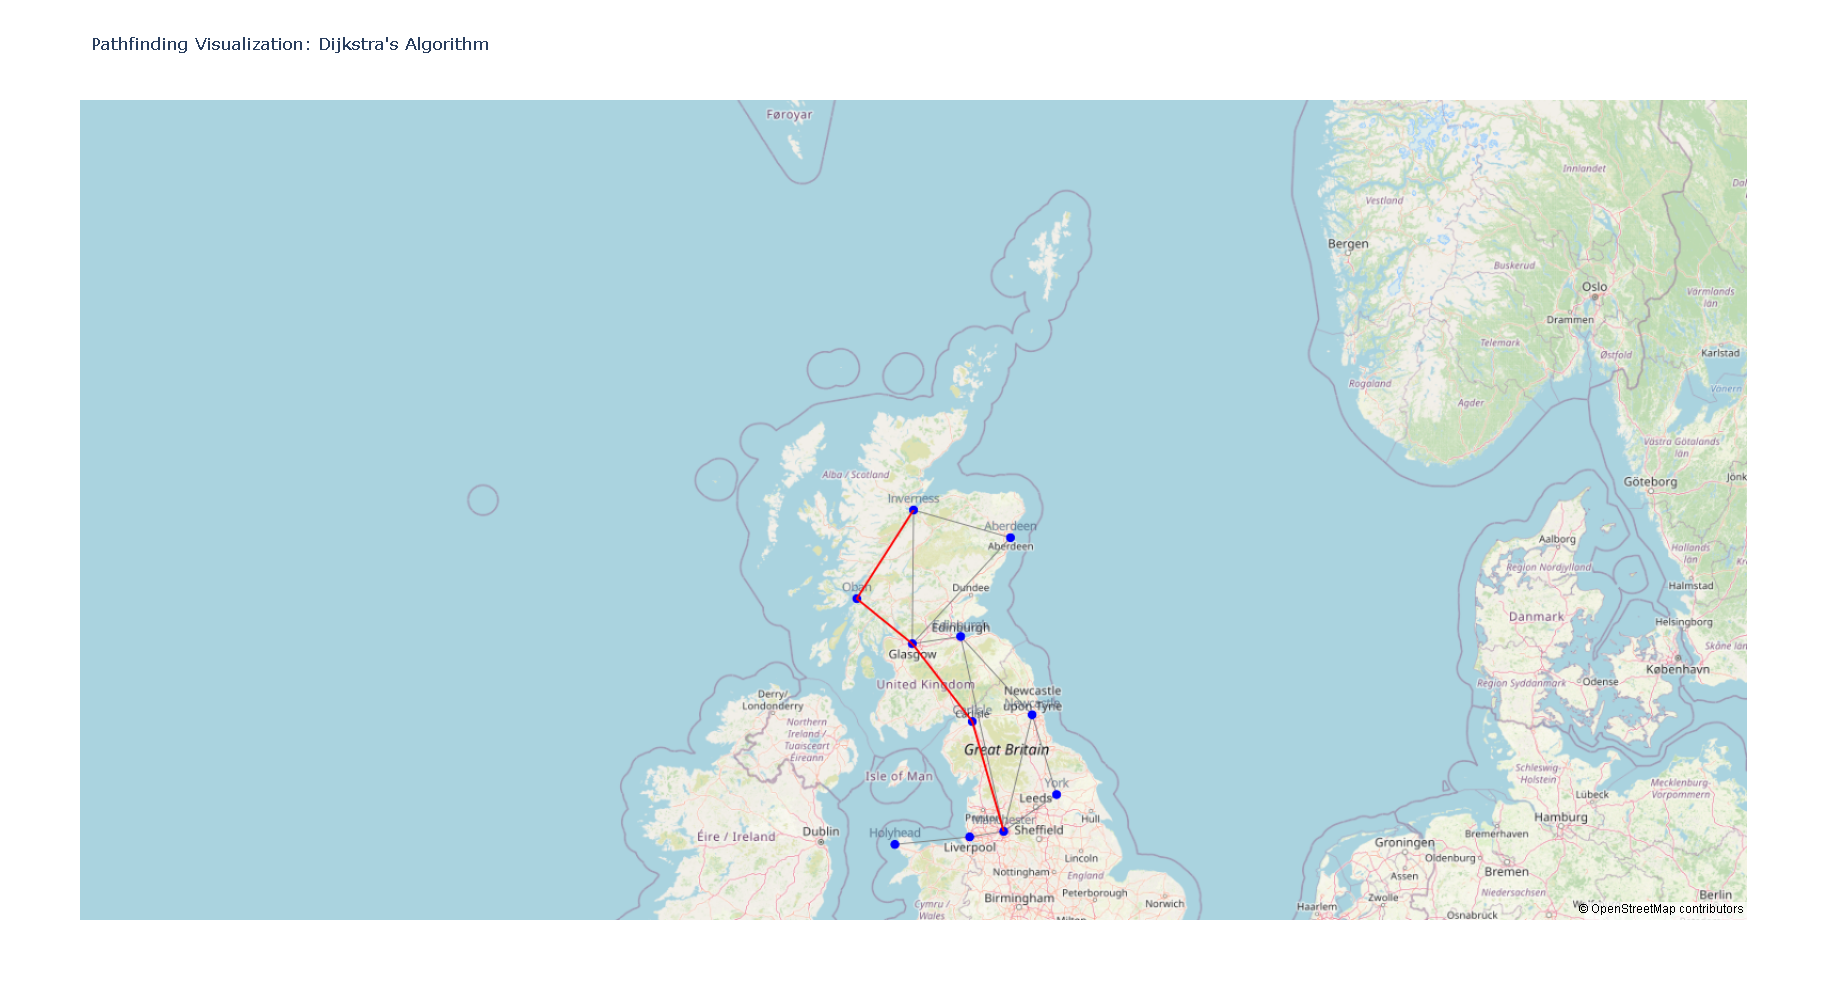


--- Traffic Conditions for Each Edge ---
Inverness -> Oban: No or Light Traffic (Factor: 1.0)
Oban -> Glasgow: No or Light Traffic (Factor: 1)
Glasgow -> Carlisle: No or Light Traffic (Factor: 1)
Carlisle -> Manchester: No or Light Traffic (Factor: 1.0)

--- A* Algorithm ---
Path: ['Inverness', 'Oban', 'Glasgow', 'Carlisle', 'Manchester']
Distance: 420.00 miles
Traffic Condition: No or Light Traffic (Factor: 1.0)
Bicycle Emissions: 0.00 kg CO₂
Ev Emissions: 42.00 kg CO₂
Petrol_car Emissions: 168.00 kg CO₂


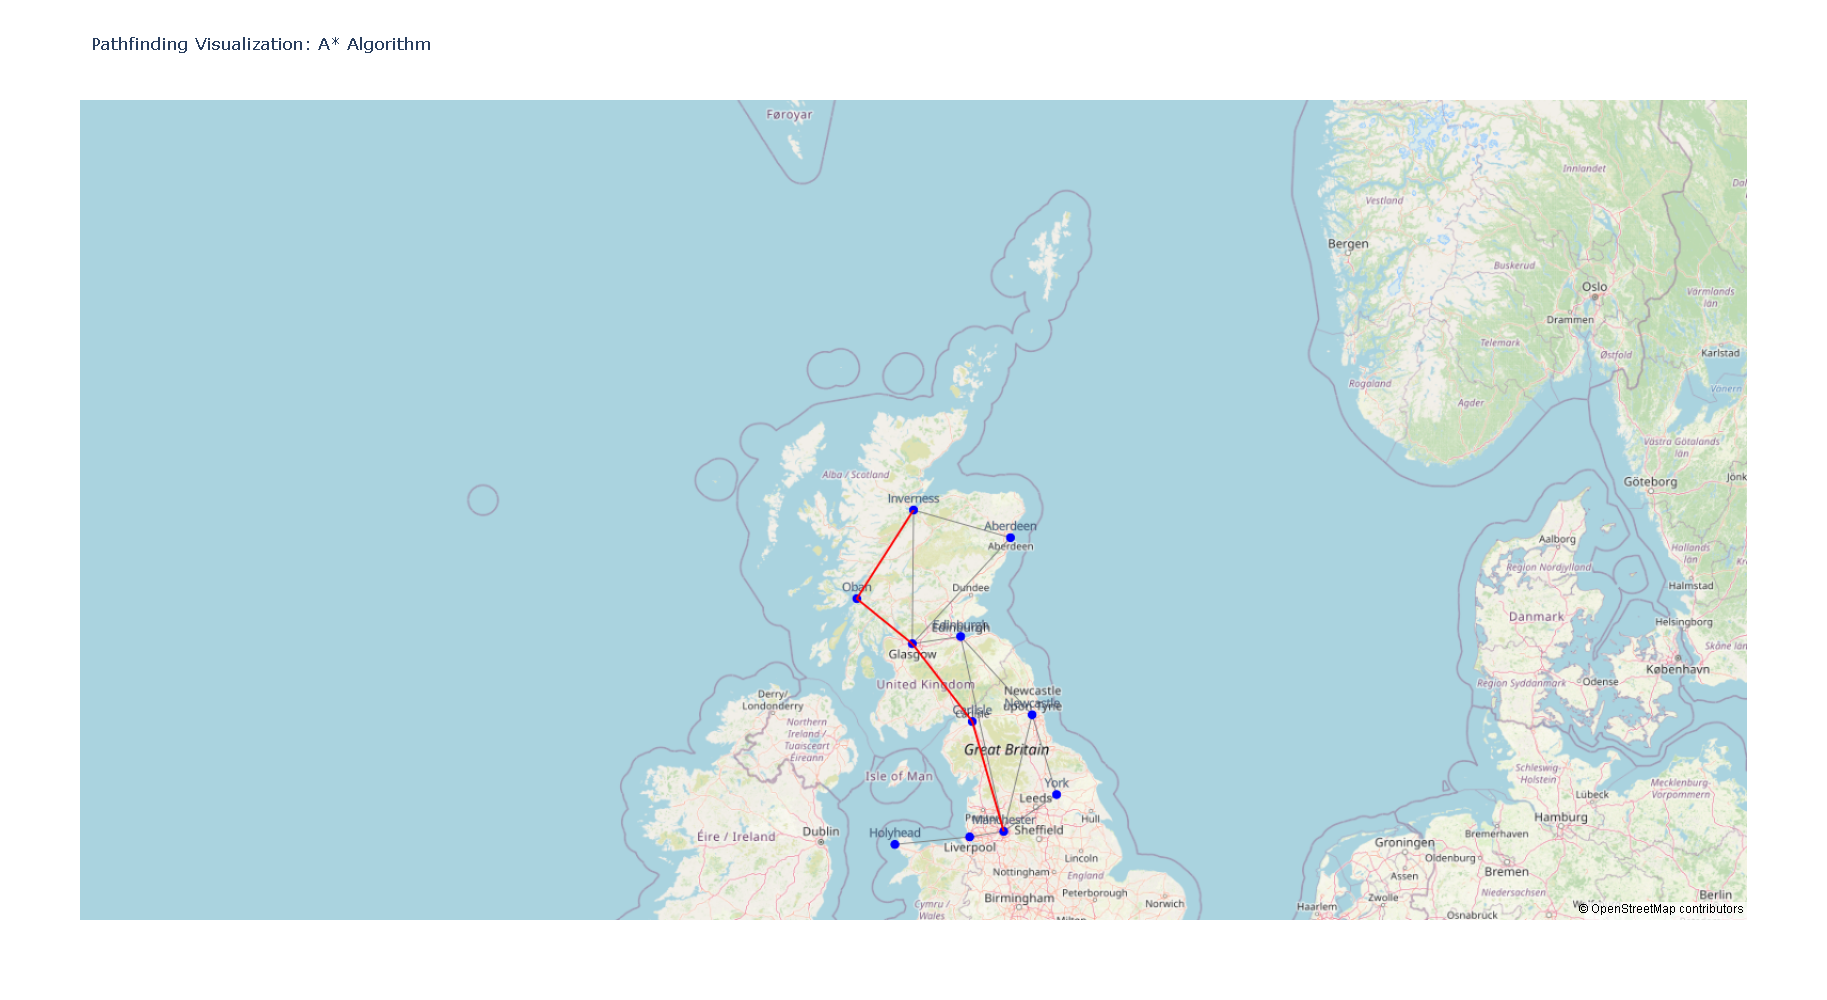


--- Traffic Conditions for Each Edge ---
Inverness -> Glasgow: Moderate Traffic (Factor: 1.5)
Glasgow -> Carlisle: No or Light Traffic (Factor: 1)
Carlisle -> Manchester: No or Light Traffic (Factor: 1.0)

--- Breadth-First Search (BFS) ---
Path: ['Inverness', 'Glasgow', 'Carlisle', 'Manchester']
Distance: 390.00 miles
Traffic Condition: Moderate Traffic (Factor: 1.5)
Bicycle Emissions: 0.00 kg CO₂
Ev Emissions: 106.88 kg CO₂
Petrol_car Emissions: 427.50 kg CO₂


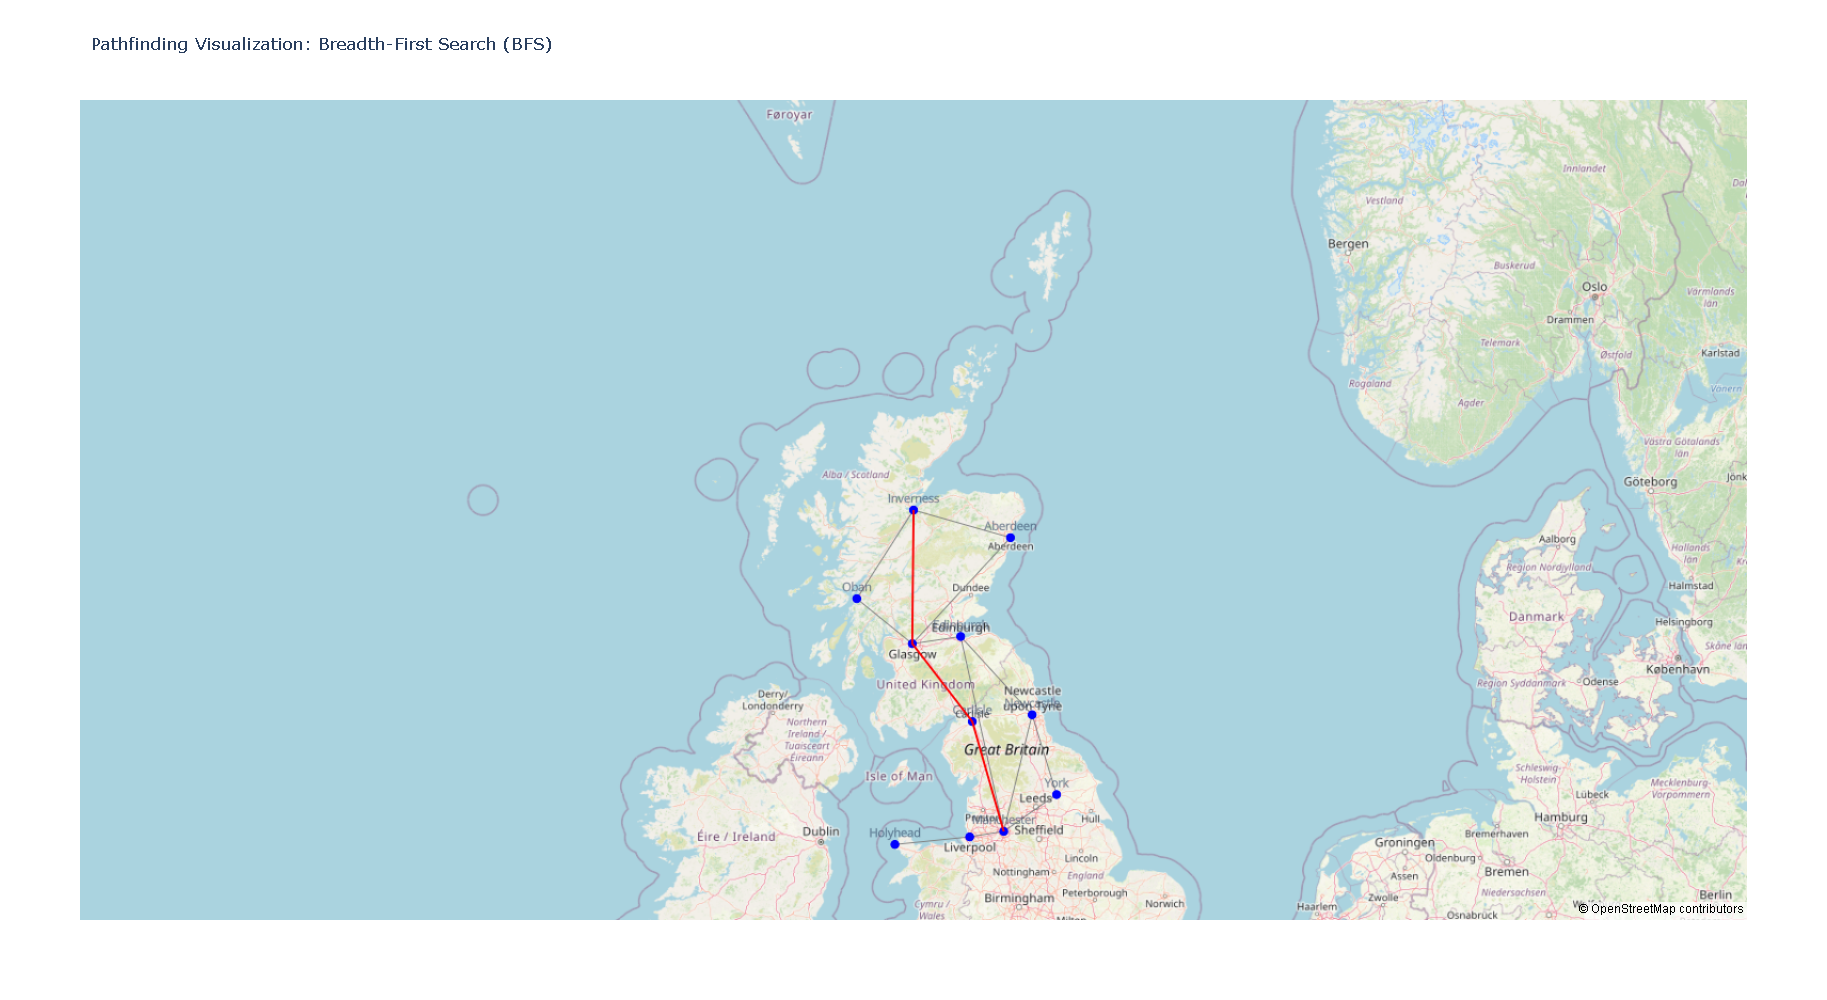


--- Traffic Conditions for Each Edge ---
Inverness -> Glasgow: Moderate Traffic (Factor: 1.5)
Glasgow -> Edinburgh: No or Light Traffic (Factor: 1.0)
Edinburgh -> Manchester: No or Light Traffic (Factor: 1.0)

--- Depth-First Search (DFS) ---
Path: ['Inverness', 'Glasgow', 'Edinburgh', 'Manchester']
Distance: 430.00 miles
Traffic Condition: Moderate Traffic (Factor: 1.5)
Bicycle Emissions: 0.00 kg CO₂
Ev Emissions: 115.88 kg CO₂
Petrol_car Emissions: 463.50 kg CO₂


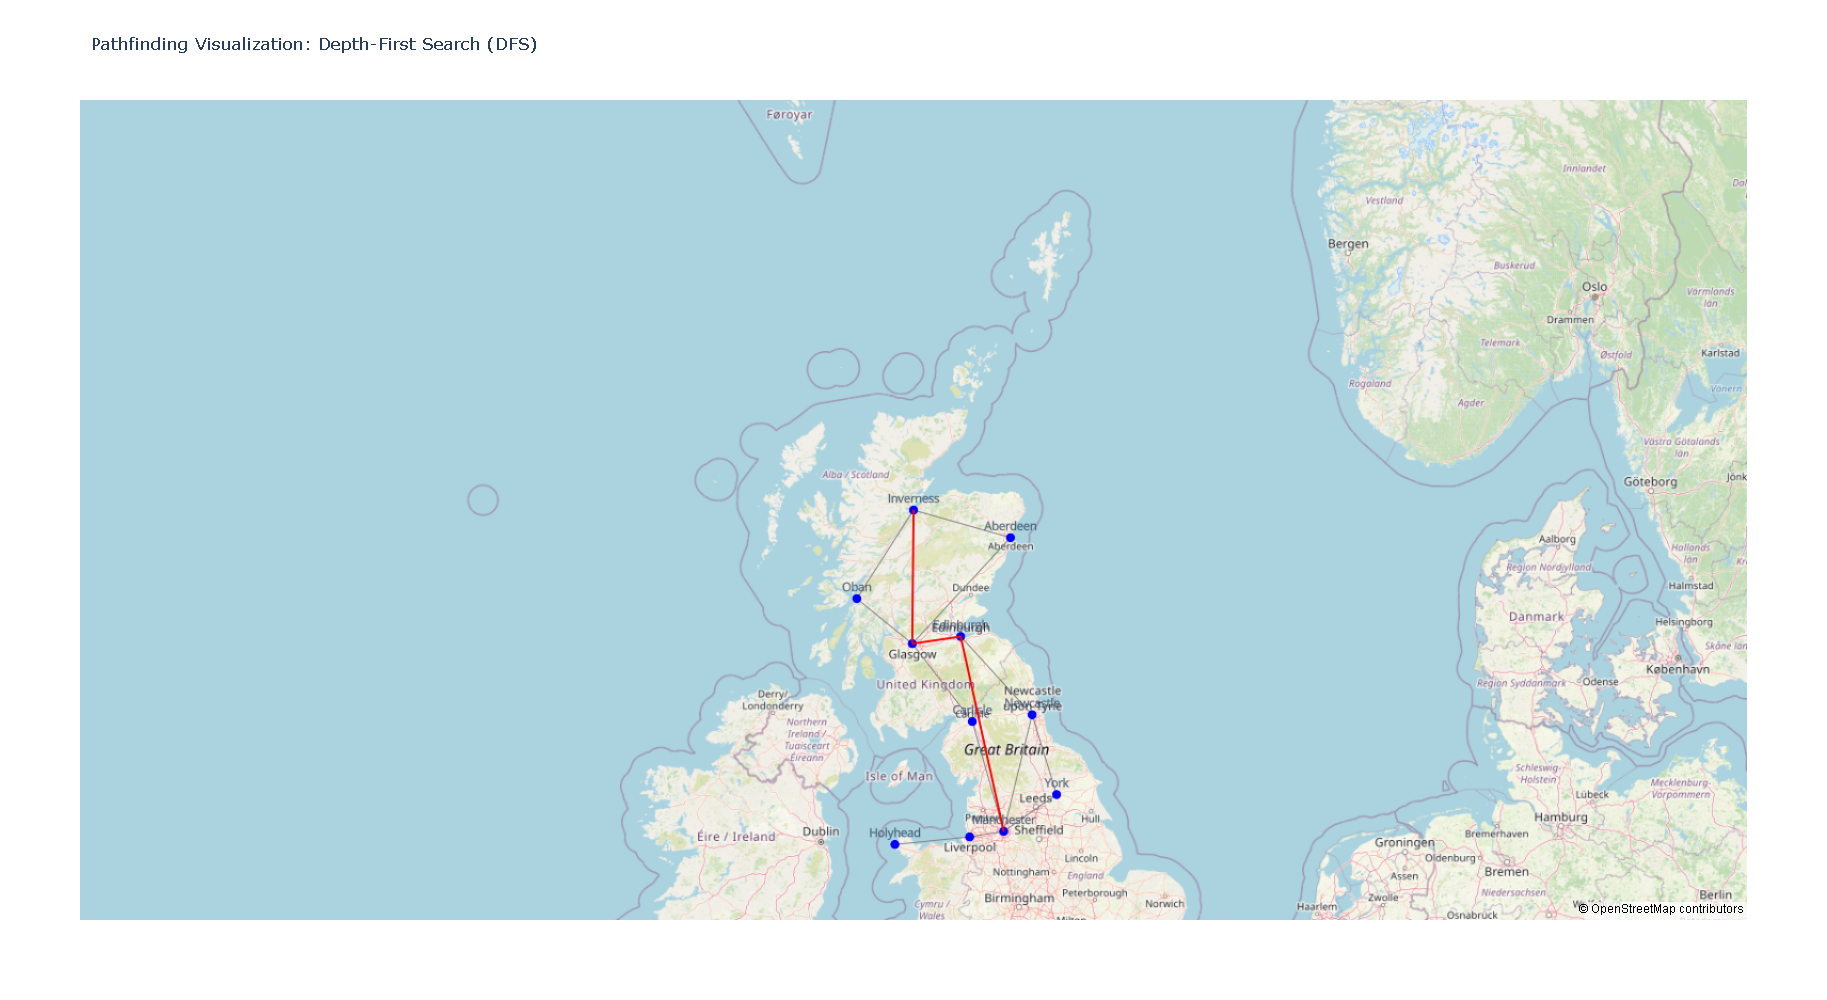

In [387]:


# Main function to run the program
def main():
    # Initialize environment and agent
    env = Environment()
    agent = Search(env)

    # Display the list of cities
    cities = env.get_cities()
    print("List of cities:")
    for i, city in enumerate(cities, 1):
        print(f"{i}. {city}")

    # Get start and end cities from the user
    try:
        start_city_index = int(input(f"Enter the number for the start city (1-{len(cities)}): ")) - 1
        end_city_index = int(input(f"Enter the number for the end city (1-{len(cities)}): ")) - 1

        if start_city_index < 0 or start_city_index >= len(cities) or end_city_index < 0 or end_city_index >= len(cities):
            print("Invalid city number entered. Please try again.")
            return

        start_city = cities[start_city_index]
        end_city = cities[end_city_index]
        print(f"Start city: {start_city}, End city: {end_city}")

        # Run all algorithms and display results
        algorithms = {
            "Dijkstra's Algorithm": agent.dijkstra,
            "A* Algorithm": agent.astar,
            "Breadth-First Search (BFS)": agent.bfs,
            "Depth-First Search (DFS)": agent.dfs
        }

        for algorithm_name, algorithm_func in algorithms.items():
            #print(f"\n--- {algorithm_name} ---")
            path = algorithm_func(start_city, end_city)
            if path:
                visualize_path(env, path, algorithm_name)
            else:
                print("No path found.")

    except ValueError:
        print("Please enter valid numbers.")


# Run the programb
if __name__ == "__main__":
    main()